**Do we need more bikes?**

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')
# dir_path = "/content/drive/MyDrive/SML-project/"

In [32]:
dir_path = "Data/"

# Hyperparameter Tuning

In [33]:
import numpy as np

# Number of fold in Cross Validation
num_folds = 5
seed = 42
# Lodistic Regression
logistic_param_grid = {
    'penalty': 'l2',
    'C':  0.03359818286283781,
    'solver': 'liblinear',
    'max_iter': 1000,
    'class_weight': None
    }
# LDA & QDA
svc_params = {
    'C': [10], # [0.1, 1, 10, 100, 1000],
    'gamma': [1], # [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'], # ['rbf', 'linear']
}
lda_param_grid = {
    'solver': ['svd'],  # Notice 'svd' is now in a list
    'tol': [0.1] # [0.0001, 0.001, 0.01, 0.1],
}
qda_param_grid = {
    'reg_param': [0.8888888], #np.linspace(0, 1, 10),
    'store_covariance': [True], # [True, False],
    'tol': [0.0001], # [0.0001, 0.001, 0.01, 0.1]
}

# KNN
knn_params = {
    'n_neighbors': 7,
    'metric': 'manhattan',
}

# Classification Tree
dt_params = {'ccp_alpha': 0.0,
              'class_weight': 'balanced',
              'criterion': 'entropy',
              'max_depth': None,
              'max_features': None,
              'max_leaf_nodes': None,
              'min_impurity_decrease': 0.0,
              'min_samples_leaf': 3,
              'min_samples_split': 2,
              'random_state': 0,
              # 'splitter': 'best',
               }
# Random forest
rf_params = {'bootstrap': True, # [True, False]
            'class_weight': 'balanced', # [balanced, balanced_subsample, None]
            'criterion': 'entropy', #[gini, entropy, log_loss]
            'max_depth': None,
            'max_features':None,
            'min_samples_leaf': 3, # [ 3, 4, 5]
            'min_samples_split': 2, # [2, 5]
            'n_estimators': 100, # [50, 100, 150]
            'random_state': 0,
            'verbose': 0,
            }

# Load and Explore Data

In [34]:
import pandas as pd
dataset_path = dir_path + "training_data.csv"
data = pd.read_csv(dataset_path, delimiter=',')
output_name = 'increase_stock'
data.head(5)

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0,0.0,10.5,44.6,16.0,low_bike_demand


# Data Preprocessing

In [35]:
label_mapping = {"low_bike_demand": 0, 'high_bike_demand': 1}
feature_names = data.columns[:-1]
class_names = list(label_mapping)

In [36]:
# Encode categorical variables
data[output_name] = data[output_name].map(label_mapping)
data.head(3)

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,0
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,0
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,0


In [37]:
# Split the data into X and y
y = data.loc[:, output_name].to_numpy()
X = data.loc[:, data.columns != output_name].to_numpy()
X.shape, y.shape

((1600, 15), (1600,))

## Hold-out

In [38]:
# Split the data into training and testing sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)
# X_train.size, y_train.size

## K-fold

In [39]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

In [40]:
import numpy as np
def k_fold(X, y, k):
  shuffle = True
  n_splits = k
  indices = np.arange(len(y))
  if shuffle:
    np.random.shuffle(indices)
  fold_sizes = np.full(n_splits, len(y) // n_splits, dtype=int)
  fold_sizes[:len(y) % n_splits] += 1

  current_idx = 0
  for fold_size in fold_sizes:
      start, stop = current_idx, current_idx + fold_size
      valid_indices = indices[start:stop]
      train_indices = np.concatenate([indices[:start], indices[stop:]])

      yield train_indices, valid_indices
      current_idx = stop

# Exploratory data analysis

In [41]:
categorical_columns = ['holiday', 'weekday', 'summertime', 'snow', 'increase_stock']
numerical_columns = [col for col in data.columns if col not in categorical_columns]
num_time_columns = ['hour_of_day', 'day_of_week', 'month']

numerical_data = data[numerical_columns]
categorical_data = data[categorical_columns]
num_time_data  = data[num_time_columns]

## Numerical features

In [42]:
numerical_data.describe().round(2)

,hour_of_day,day_of_week,month,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility
count,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00
mean,11.37,3.02,6.47,15.21,7.75,63.93,0.12,0.04,13.08,64.32,15.34
std,6.95,2.01,3.45,9.26,10.03,19.08,0.92,0.42,7.76,32.75,2.32
min,0.00,0.00,1.00,-9.10,-18.40,15.85,0.00,0.00,0.00,0.00,0.10
25%,5.00,1.00,3.00,7.70,-0.80,47.84,0.00,0.00,7.50,28.80,16.00
50%,12.00,3.00,6.00,15.50,8.30,65.18,0.00,0.00,12.30,79.30,16.00
75%,17.00,5.00,9.00,23.20,16.80,79.96,0.00,0.00,17.60,92.80,16.00
max,23.00,6.00,12.00,35.60,24.30,99.89,25.87,6.71,43.80,100.00,16.00


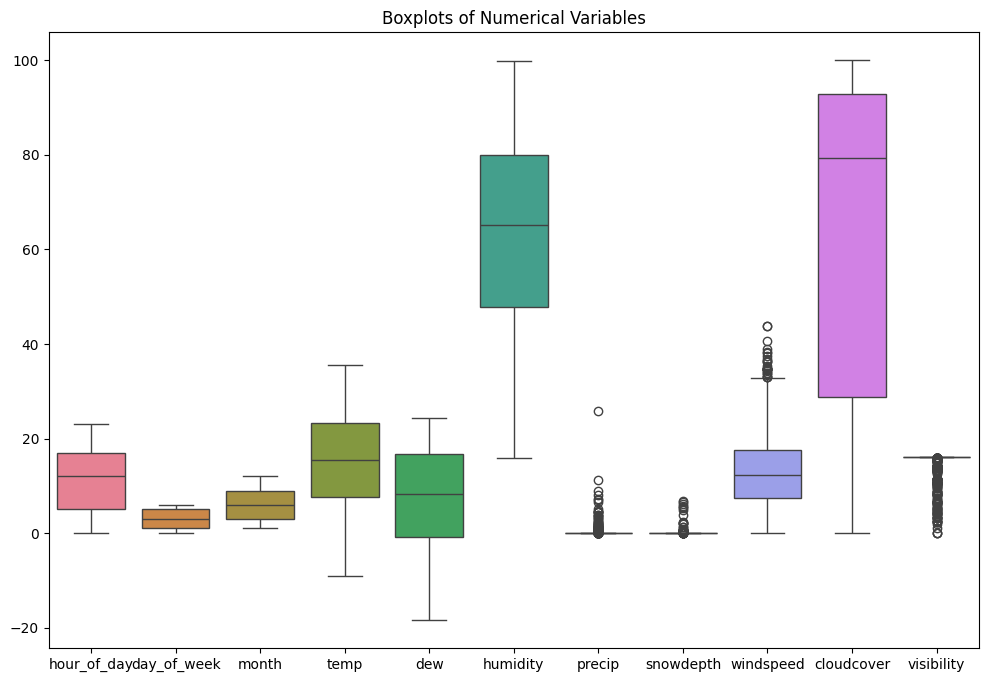

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
# Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_columns])
plt.title('Boxplots of Numerical Variables')
plt.show()

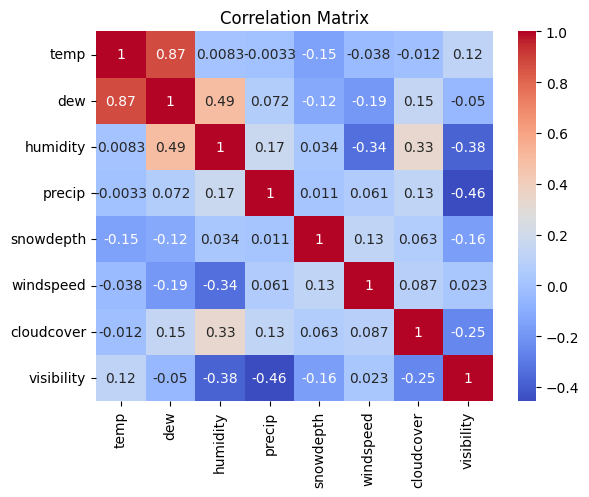

In [44]:
# Correlation
correlation_matrix = data[['temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Categorical Features


In [45]:
for column in categorical_columns:
    value_counts = categorical_data[column].value_counts()
    print(f"Distribution for {column}:")
    print(f"Value\tCount")
    for index, count in value_counts.items():
        print(f"{index}\t{count}")
    print("="*20)
    print()

Distribution for holiday:
Value	Count
0	1547
1	53

Distribution for weekday:
Value	Count
1	1136
0	464

Distribution for summertime:
Value	Count
1	1030
0	570

Distribution for snow:
Value	Count
0	1600

Distribution for increase_stock:
Value	Count
0	1312
1	288



## Trend Analysis

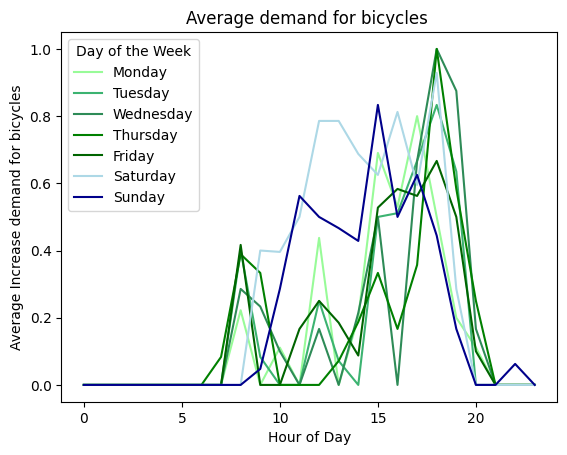

In [46]:
# RUN MAPPING INCREASE STOCK BEFORE!
# Aggregation Hour_of_day, Day_of_Week, Month
grouped_data = data.groupby(['hour_of_day', 'day_of_week', 'month']).mean()['increase_stock']
grouped_data = grouped_data.reset_index()
day_order = [0, 1, 2, 3, 4, 5, 6]
day_palette = {0: 'palegreen', 1: 'mediumseagreen', 2: 'seagreen', 3: 'green', 4: 'darkgreen', 5: 'lightblue', 6: 'darkblue'}

sns.lineplot(x='hour_of_day', y='increase_stock', hue='day_of_week', palette=day_palette, data=grouped_data, ci=None)

plt.title('Average demand for bicycles ')
plt.xlabel('Hour of Day')
plt.ylabel('Average Increase demand for bicycles')
plt.legend(title='Day of the Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

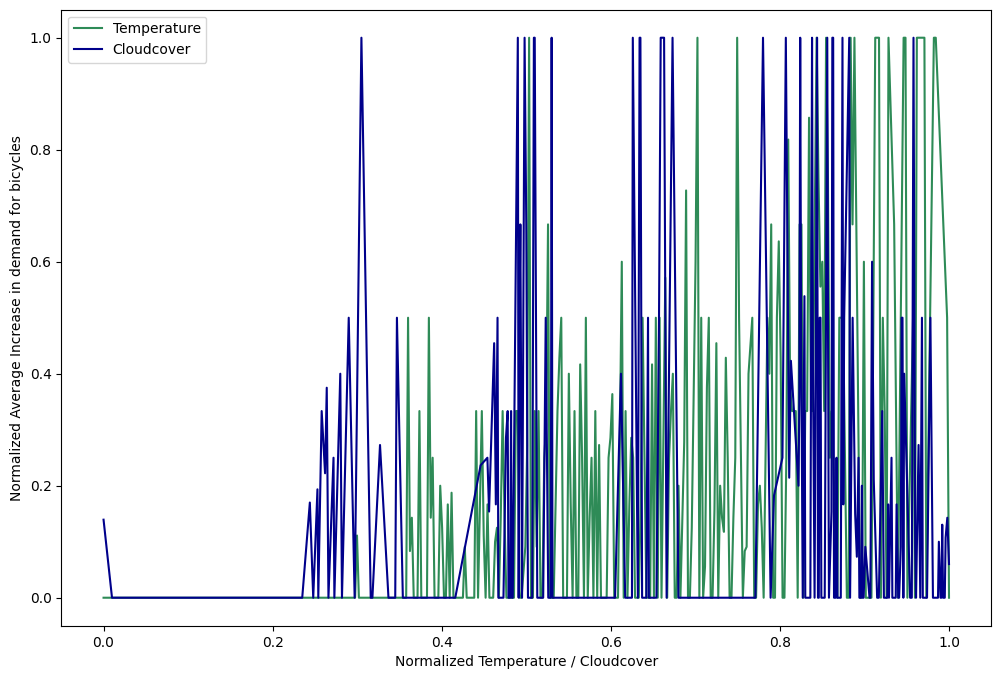

In [47]:
# Trend Temperature/Cloudcover vs. Increase_Stock
from sklearn.preprocessing import MinMaxScaler

grouped_data_temp = data.groupby(['temp']).mean()['increase_stock']
grouped_data_temp = grouped_data_temp.reset_index()

grouped_data_cloudcover = data.groupby(['cloudcover']).mean()['increase_stock']
grouped_data_cloudcover = grouped_data_cloudcover.reset_index()

scaler = MinMaxScaler()
grouped_data_temp[['temp', 'increase_stock']] = scaler.fit_transform(grouped_data_temp[['temp', 'increase_stock']])
grouped_data_cloudcover[['cloudcover', 'increase_stock']] = scaler.fit_transform(grouped_data_cloudcover[['cloudcover', 'increase_stock']])

color_temp = "seagreen"
color_cloudcover = "darkblue"

plt.figure(figsize=(12, 8))
sns.lineplot(x='temp', y='increase_stock', data=grouped_data_temp, ci=None, estimator='mean', err_style='band', color=color_temp, label='Temperature')
sns.lineplot(x='cloudcover', y='increase_stock', data=grouped_data_cloudcover, ci=None, estimator='mean', err_style='band', color=color_cloudcover, label='Cloudcover')

plt.xlabel('Normalized Temperature / Cloudcover')
plt.ylabel('Normalized Average Increase in demand for bicycles')
plt.legend()
plt.show()

### Chi-Test

In [48]:
from scipy.stats import chi2_contingency
# Holiday vs. increase_stock
contingency_table = pd.crosstab(data['holiday'], data['increase_stock'])
print(contingency_table)

chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square value: {chi2}')
print(f'P-value: {p}')

alpha = 0.05
print(f'Significance level: {alpha}')
print(f'Chi-square test {"rejects" if p < alpha else "does not reject"} the null hypothesis')


increase_stock     0    1
holiday                  
0               1268  279
1                 44    9
Chi-square value: 0.0002115375277985876
P-value: 0.9883957129725334
Significance level: 0.05
Chi-square test does not reject the null hypothesis


In [49]:
# Weekday vs. increase_stock
contingency_table = pd.crosstab(data['weekday'], data['increase_stock'])
print(contingency_table)

chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square value: {chi2}')
print(f'P-value: {p}')

alpha = 0.05
print(f'Significance level: {alpha}')
print(f'Chi-square test {"rejects" if p < alpha else "does not reject"} the null hypothesis')


increase_stock    0    1
weekday                 
0               348  116
1               964  172
Chi-square value: 21.032661486158336
P-value: 4.515202807870371e-06
Significance level: 0.05
Chi-square test rejects the null hypothesis


# Feature Selection

In [50]:
dropped_col = [ 10, 11]  # snow & snow_depth
X_dropped = np.delete(X, dropped_col, axis=1)
feature_names_dropped = np.array([feature_names[i] for i in range(len(feature_names)) if i not in dropped_col])

feature_names_dropped

array(['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday',
       'summertime', 'temp', 'dew', 'humidity', 'precip', 'windspeed',
       'cloudcover', 'visibility'], dtype='<U11')

# Feature Scaling

In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_dropped)


# Models

## 1. Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sn


import warnings
warnings.filterwarnings("ignore")

class LogisticClassifier:
    def __init__(self, param_grid, verbose = False):
      self.verbose = verbose
      self.model = LogisticRegression(**param_grid)

    # def preprocess(self, X_train):
    #   snow_columns = [10, 11]
    #   X_train = np.delete(X_train, snow_columns, axis = 1)
    #   return X_train


    def fit(self, X_train, y_train):
      # X_train = self.preprocess(X_train)
      self.model.fit(X_train, y_train)

    def predict(self, X_test):
      # X_test = self.preprocess(X_test)
      return self.model.predict(X_test)
    def predict_proba(self, X_test):
      # X_test = self.preprocess(X_test)
      return self.model.predict_proba(X_test)


## 2. LDA & QDA

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import random
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


class DiscriminantAnalysisModel:
    def __init__(self, model_type, lda_qda_params, svc_params):
        self.model_type = model_type
        self.lda_qda_params = lda_qda_params
        self.svc_params = svc_params
        if self.model_type == 'LDA':
            self.lda_qda_model = GridSearchCV(LinearDiscriminantAnalysis(), self.lda_qda_params, cv=5, scoring='accuracy')
            self.svc_model = GridSearchCV(SVC(probability=True), self.svc_params, cv=5, scoring='accuracy')
        elif self.model_type == 'QDA':
            self.lda_qda_model = GridSearchCV(QuadraticDiscriminantAnalysis(), self.lda_qda_params, cv=5, scoring='accuracy')
            self.svc_model = None  # SVC is not used with QDA

    def fit(self, X_train, y_train):
        self.lda_qda_model.fit(X_train, y_train)
        if self.model_type == 'LDA':
            X_train_transformed = self.lda_qda_model.best_estimator_.transform(X_train)
            self.svc_model.fit(X_train_transformed, y_train)


    def predict(self, X_test):
        if self.model_type == 'LDA':
            X_test_transformed = self.lda_qda_model.best_estimator_.transform(X_test)
            return self.svc_model.best_estimator_.predict(X_test_transformed)
        elif self.model_type == 'QDA':
            return self.lda_qda_model.best_estimator_.predict(X_test)

    def predict_proba(self, X_test):
        if self.model_type == 'LDA':
            X_test_transformed = self.lda_qda_model.best_estimator_.transform(X_test)
            return self.svc_model.best_estimator_.predict_proba(X_test_transformed)
        elif self.model_type == 'QDA':
            return self.lda_qda_model.best_estimator_.predict_proba(X_test)


## 3. K-Nearest Neighbour

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class Knn:
    def __init__(self, parameters, verbose = True):
        self.verbose = verbose
        self.pca = None
        self.model = KNeighborsClassifier(**parameters)
        # self.model = GridSearchCV(knn, parameters, cv=5)

    def preprocessing(self, x):
        # return x
        if self.pca is None:
          self.pca = PCA()
          return self.pca.fit_transform(x)
        else:
          return self.pca.transform(x)
    def fit(self, X_train, y_train):
        X_train_pca = self.preprocessing(X_train)
        self.model.fit(X_train_pca, y_train)
    def best_params(self, text):
      return self.model.best_params_[text]

    def predict(self, X_valid):
        X_valid_pca = self.preprocessing(X_valid)
        return self.model.predict(X_valid_pca)
        # y_pred= self.model.best_estimator_.predict(X_valid_pca)

    def predict_proba(self, X_valid):
        X_valid_pca = self.preprocessing(X_valid)
        return self.model.predict_proba(X_valid_pca)
        # y_pred= self.model.best_estimator_.predict_proba(X_valid_pca)

## 4. Tree-based methods

In [55]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree


# plt.ion()
class ClassificationTree:

    def __init__(self, params, verbose = True):
        self.verbose = verbose
        self.model = DecisionTreeClassifier(**params)
        # self.dropped_col = [10, 11] #[3, 5, 10, 11, 14]

    def fit(self, X_train, y_train):
        X_train_preprocessed = self.preprocessing(X_train, y_train)
        return self.model.fit(X_train_preprocessed, y_train)

    def preprocessing(self, X, y=None):
        # X_dropped = np.delete(X, self.dropped_col, axis=1)
        return X

    def predict(self, X_test):
        X_test_preprocessed = self.preprocessing(X_test)
        return self.model.predict(X_test_preprocessed)

    def predict_proba(self, X_test):
        X_test_preprocessed = self.preprocessing(X_test)
        return self.model.predict_proba(X_test_preprocessed)

    def get_parameters(self):
        # return self.model.best_params_
        return self.model.get_params()

    def visualize_tree(self, feature_names=None, class_names=None):
        plt.figure(figsize=(20, 10))
        plot_tree(self.model, filled=True, feature_names=feature_names,
                  class_names=class_names, rounded=True, precision=2)
        plt.show()



class RandomForest:

    def __init__(self, params, verbose = True):
        self.verbose = verbose
        # self.dropped_col = [10, 11] #[3, 5, 10, 11, 14]
        self.model = RandomForestClassifier(**params)

        # Perform Grid Search
        # rf = RandomForestClassifier(random_state=42)
        # self.model = GridSearchCV(rf, param_grid=params, cv=5, scoring='accuracy')


    def fit(self, X_train, y_train):
        X_train_preprocessed = self.preprocessing(X_train, y_train)
        return self.model.fit(X_train_preprocessed, y_train)

    def predict(self, X_valid):
        X_test_preprocessed = self.preprocessing(X_valid)
        # return self.model.best_estimator_.predict(X_test_preprocessed)
        return self.model.predict(X_test_preprocessed)

    def predict_proba(self, X_test):
        X_test_preprocessed = self.preprocessing(X_test)
        return self.model.predict_proba(X_test_preprocessed)

    def preprocessing(self, X, y=None):
        # X_dropped = np.delete(X, self.dropped_col, axis=1)
        return X

    def get_params(self):
        # return  self.model.best_params_
        return self.model.get_params()

    def plot_most_important_features(self, feature_names):
        
        feature_importance = self.model.feature_importances_
        sorted_idx = feature_importance.argsort()
        custom_palette = sns.color_palette("Purples", n_colors=len(feature_importance))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], color = custom_palette)
        plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
        plt.ylabel('Features')
        plt.xlabel('Feature Importance')
        plt.savefig('most_important.pdf', bbox_inches='tight')
        plt.show()


class Bagging:

    def __init__(self,base_classifier_params, verbose=True):
        self.verbose = verbose
        # base_classifier = RandomForestClassifier(**base_classifier_params)
        base_classifier = DecisionTreeClassifier(**base_classifier_params)
        self.model = BaggingClassifier(estimator =base_classifier,  n_estimators=100)

    def fit(self, X_train, y_train):
        return self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

    def get_params(self):
        return self.model.get_params()



# Train

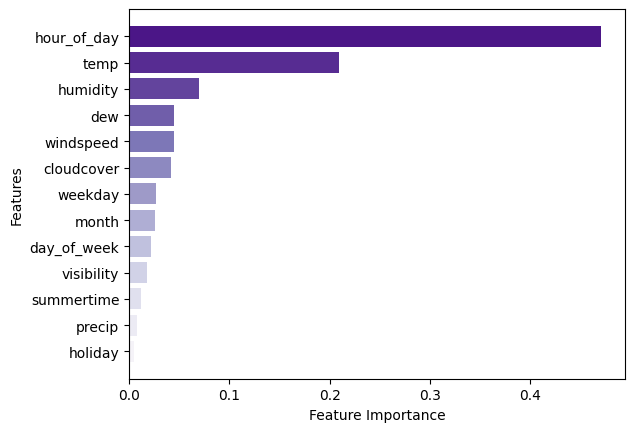

5

In [56]:

logistic_probe_y_list = []
lda_probe_y_list = []
qda_probe_y_list = []
knn_probe_y_list = []
ct_probe_y_list = []
rf_probe_y_list = []
bag_probe_y_list = []
naive_probe_y_list = []
y_valid_list = []
once = True
# Iterate over the folds to get training and validation indices
# manuall k-fold funciton
# for train_index, valid_index in k_fold(X_normalized, y, num_folds):
# built-in k-fold funciton

for train_index, valid_index in kf.split(X_normalized, y):
    X_train, X_valid = X_normalized[train_index], X_normalized[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    y_valid_list.append(y_valid)
    naive_probe_y_list.append(np.ones(y_valid.shape[0]))

    # Logistic Classifier
    logistic_model = LogisticClassifier(logistic_param_grid)
    logistic_model.fit(X_train, y_train)
    # Extracting probabilities of the positive class
    logistic_probe_y = logistic_model.predict_proba(X_valid)[:, 1]
    logistic_probe_y_list.append(logistic_probe_y)

    # LDA
    lda_model = DiscriminantAnalysisModel('LDA', lda_param_grid, svc_params)
    lda_model.fit(X_train, y_train)
    # Extracting probabilities of the positive class
    lda_probe_y = lda_model.predict_proba(X_valid)[:, 1]
    lda_probe_y_list.append(lda_probe_y)

    # QDA
    qda_model = DiscriminantAnalysisModel('QDA', qda_param_grid, None)
    qda_model.fit(X_train, y_train)
    # Extracting probabilities of the positive class
    qda_probe_y = qda_model.predict_proba(X_valid)[:, 1]
    qda_probe_y_list.append(qda_probe_y)

    # KNN
    knn_model = Knn(knn_params)
    knn_model.fit(X_train, y_train)
    # Extracting probabilities of the positive class
    knn_probe_y = knn_model.predict_proba(X_valid)[:, 1]
    knn_probe_y_list.append(knn_probe_y)

    # Classification Tree
    ct_model = ClassificationTree(dt_params)
    ct_model.fit(X_train, y_train)
    # Extracting probabilities of the positive class
    ct_probe_y = ct_model.predict_proba(X_valid)[:, 1]
    ct_probe_y_list.append(ct_probe_y)

    # Random Forest
    rf_model = RandomForest(rf_params, verbose=True)
    rf_model.fit(X_train, y_train)

    # Extracting probabilities of the positive class
    rf_probe_y = rf_model.predict_proba(X_valid)[:, 1]
    rf_probe_y_list.append(rf_probe_y)

    if once:
      once = False
      rf_model.plot_most_important_features(feature_names_dropped)

    # Bagging
    bag_model = Bagging(base_classifier_params=dt_params)
    bag_model.fit(X_train, y_train)
    # Extracting probabilities of the positive class
    bag_probe_y = bag_model.predict_proba(X_valid)[:, 1]
    bag_probe_y_list.append(bag_probe_y)

len(y_valid_list)

# Model Comparison

In [57]:
from sklearn.metrics import roc_curve, auc
def evaluate(y_true_list, y_probs_list, verbose = False):

  accuracy = []
  precision = []
  recall = []
  f1 = []
  cm = []
  fpr_list, tpr_list = [], []
  # clas = []
  for k, (y_true, y_probs) in enumerate(zip(y_true_list, y_probs_list)):
    y_pred = [1 if prob >= 0.5 else 0 for prob in y_probs]
    cm.append(confusion_matrix(y_true, y_pred))
    accuracy.append(accuracy_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred))
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    # fpr_list.append(fpr)
    # tpr_list.append(tpr)
    # clas.append(classification_report(y_true, y_pred))
    if verbose:
      print('')
      print(f"for {k}th iteration:")
      print("Confusion Matrix:")
      print(cm[-1])
      print(f"> Accuracy: {accuracy[-1]}")
      print(f"> Precision: {precision[-1]}")
      print(f"> Recall: {recall[-1]}")
      print(f"> F1 Score: {f1[-1]}")
      # print(f"> Report: {clas[-1]}")


  # Calculate the mean and standard deviation of each metric
    mean_cm = np.mean(cm ,axis = 0)
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    # mean_fpr = np.mean(fpr_list, axis = 0)
    # mean_fpr[-1] = 1
    # mean_tpr = np.mean(tpr_list, axis = 0)
    # mean_fpr[-1] = 1

    if verbose:
      # Print or use the mean values as overall performance metrics
      print(f"Mean Accuracy: {mean_accuracy:.4f}")
      print(f"Mean Precision: {mean_precision:.4f}")
      print(f"Mean Recall: {mean_recall:.4f}")
      print(f"Mean F1 Score: {mean_f1:.4f}")
  return mean_cm, mean_accuracy, mean_precision, mean_recall, mean_f1, fpr, tpr

In [58]:
naive_results = evaluate(y_valid_list, naive_probe_y_list)
logistic_results = evaluate(y_valid_list, logistic_probe_y_list)
lda_results = evaluate(y_valid_list, lda_probe_y_list)
qda_results = evaluate(y_valid_list, qda_probe_y_list)
knn_resutls = evaluate(y_valid_list, knn_probe_y_list)
rf_results = evaluate(y_valid_list, rf_probe_y_list)
bag_results = evaluate(y_valid_list, bag_probe_y_list)


In [59]:
models = ['Naive', 'Logistic Regression', 'LDA', 'QDA','KNN', 'Random Forest', 'Bagging']
metrics = ['Confusion matrix', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

## Metric comparison

In [60]:
results = {'Model': models}
for i, metric in enumerate(metrics):
    if i == 0:
      # confusiton matrix
      continue
    results[metric] = [
        naive_results[i],
        logistic_results[i],
        lda_results[i],
        qda_results[i],
        knn_resutls[i],
        rf_results[i],
        bag_results[i],
        ]

results_pd = pd.DataFrame(results)
results_pd

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive,0.180000,0.180000,1.000000,0.304778
1,Logistic Regression,0.847500,0.675795,0.330560,0.437861
2,LDA,0.848125,0.675566,0.313616,0.424421
3,QDA,0.830625,0.528221,0.511445,0.515346
4,KNN,0.843125,0.596490,0.415834,0.488278
5,Random Forest,0.896250,0.710986,0.724407,0.715306
6,Bagging,0.899375,0.715954,0.731006,0.722164


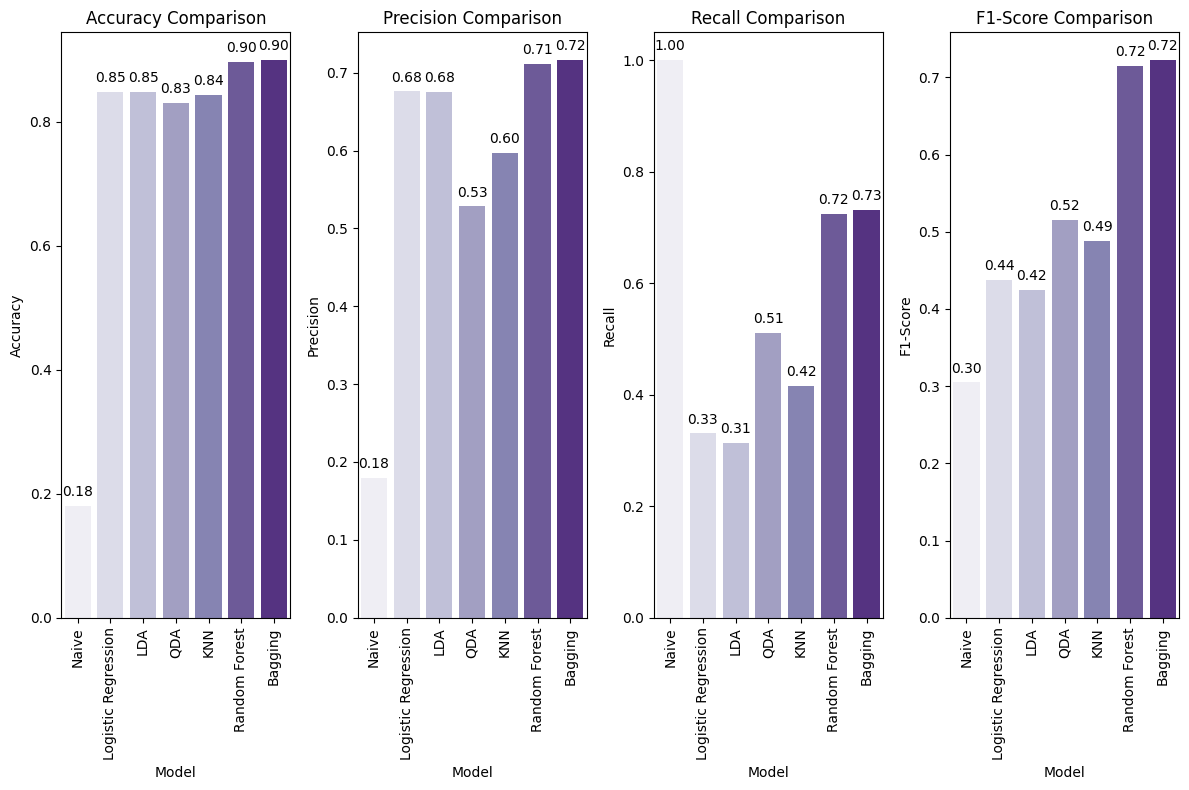

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Increase the height to 8 inches

# Assuming 'results_pd' is your DataFrame and 'metrics' is a list of metric names
for i, metric in enumerate(metrics[1:]):
    plt.subplot(1, 4, i + 1)
    custom_colors = ['#460f6e', '#5e1783', '#762096', '#8f299f', '#a842ab']
    ax = sns.barplot(x='Model', y=metric, data=results_pd, palette='Purples')

    # Annotating each bar with its value
    values = [p.get_height() for p in ax.patches]
    for p, value in zip(ax.patches, values):
        height = p.get_height()
        ax.annotate(f'{value:.2f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=90, ha='center')

plt.tight_layout()
# plt.savefig('metric_comp.png')
plt.savefig('metric_comp.pdf', bbox_inches='tight')
plt.show()


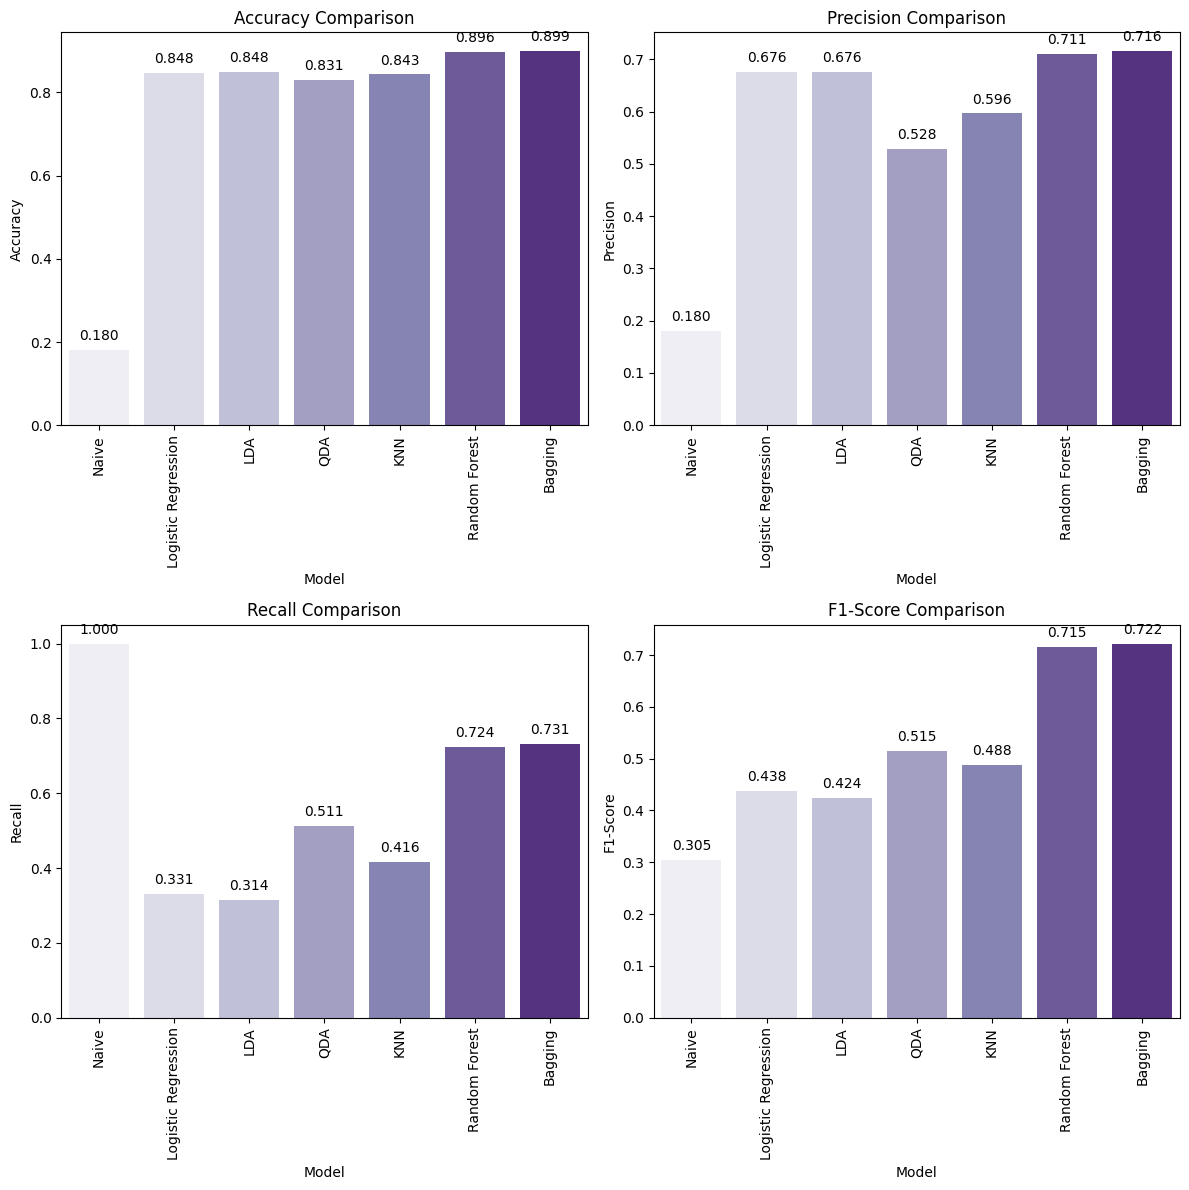

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))  # Increase the figure size for the 2x2 grid

# Assuming 'results_pd' is your DataFrame and 'metrics' is a list of metric names
for i, metric in enumerate(metrics[1:]):
    plt.subplot(2, 2, i + 1)  # Adjust the number of rows and columns here
    custom_colors = ['#460f6e', '#5e1783', '#762096', '#8f299f', '#a842ab']
    ax = sns.barplot(x='Model', y=metric, data=results_pd, palette='Purples')

    # Annotating each bar with its value
    values = [p.get_height() for p in ax.patches]
    for p, value in zip(ax.patches, values):
        height = p.get_height()
        ax.annotate(f'{value:.3f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=90, ha='center')

plt.tight_layout()
# plt.savefig('metric_comp.png')
plt.savefig('metric_comp.pdf', bbox_inches='tight')
plt.show()


## Confusion Matrix

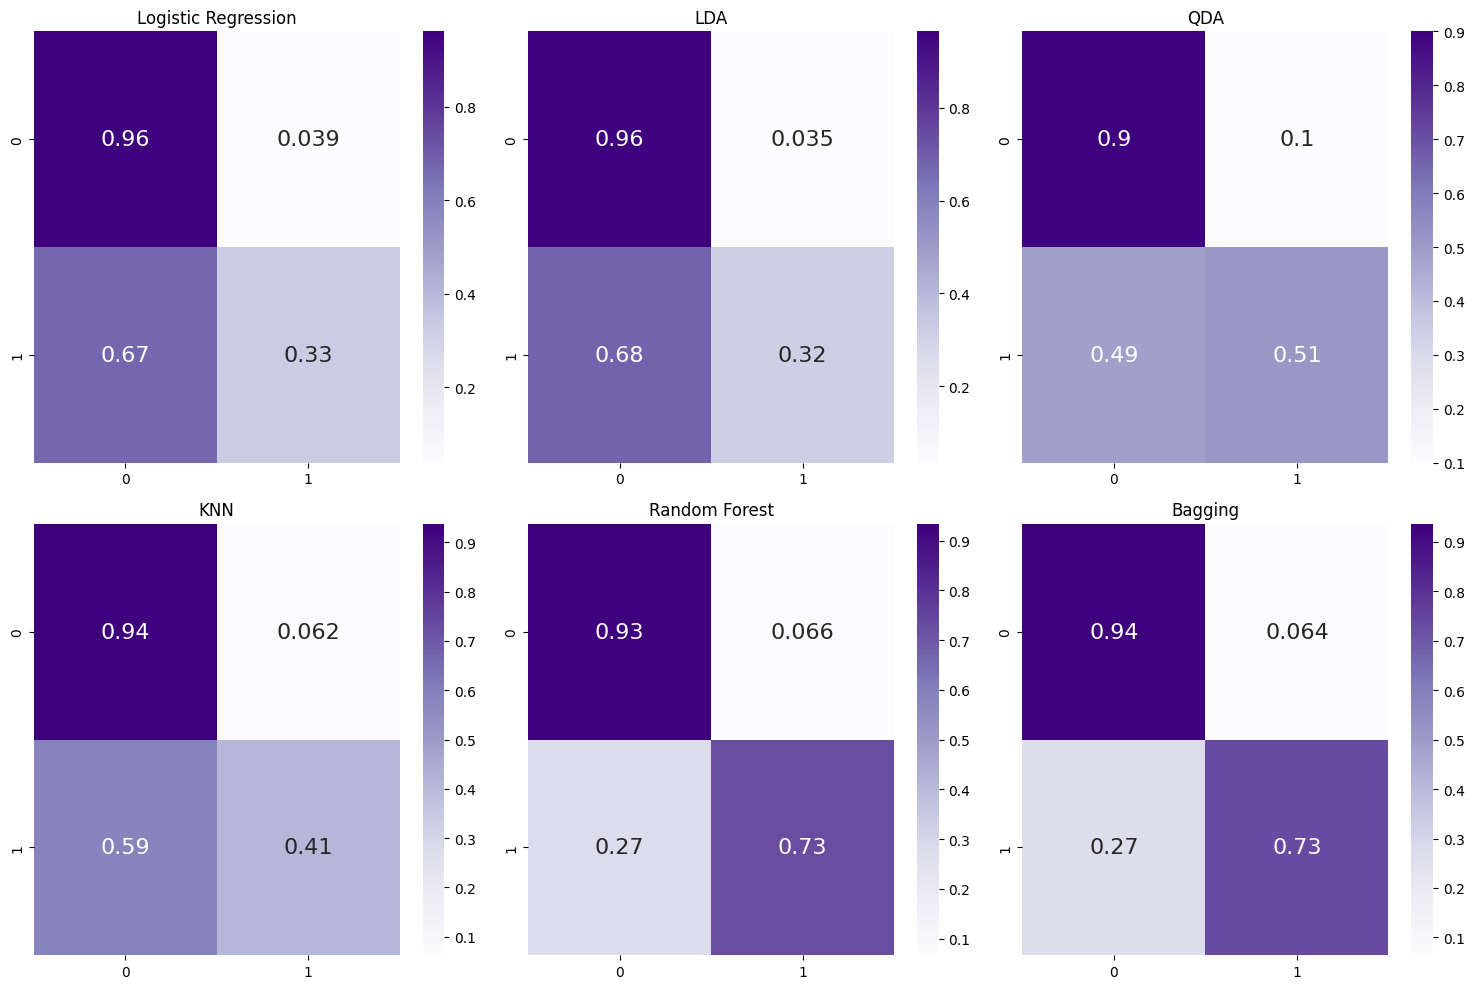

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrices = [
    logistic_results[0],
    lda_results[0],
    qda_results[0],
    knn_resutls[0],
    rf_results[0],
    bag_results[0],
]
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot each confusion matrix in a subplot with a purple colormap
for i, ax in enumerate(axes.flatten()):
    cm = conf_matrices[i].astype('float') / conf_matrices[i].sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, cmap="Purples", ax=ax, annot_kws={"size": 16})  # Adjust the fontsize here
    ax.set_title(models[i+1])

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('conf_matrix.pdf', bbox_inches='tight')
plt.show()


## ROC Curve

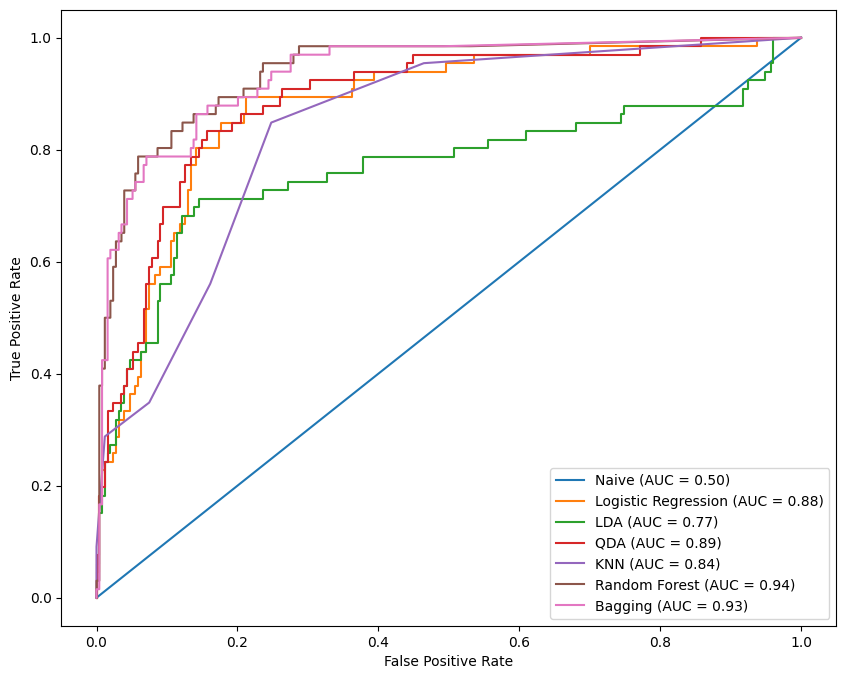

In [64]:
# ROC Curve
plt.figure(figsize=(10, 8))

fpr_values = [
    naive_results[-2],
    logistic_results[-2],
    lda_results[-2],
    qda_results[-2],
    knn_resutls[-2],
    rf_results[-2],
    bag_results[-2],
]
tpr_values = [
    naive_results[-1],
    logistic_results[-1],
    lda_results[-1],
    qda_results[-1],
    knn_resutls[-1],
    rf_results[-1],
    bag_results[-1],
]
# Plot ROC curves for each model
for tpr, fpr, model_name in zip(tpr_values, fpr_values, models):
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
# plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for Multiple Models')
plt.legend(loc='lower right')

plt.savefig('roc_curve.pdf', bbox_inches='tight')
# Show the plot
plt.show()